# Dependencies

In [105]:
import tensorflow as tf
import numpy as np
import os
from collections import Counter
from matplotlib import pyplot as plt
import pandas as pd
#from sklearn.metrics import confusion_matrix

In [255]:
import sys
sys.path.append('/usr/local/opt/opencv/lib//python3.6/site-packages/')
import cv2

# Load Data

In [256]:
def get_rec_files(path,ext):
    content = os.listdir(path)
    if len(content) == 0:
        return []
    if ".DS_Store" in content:
        content.remove(".DS_Store")
    if content[0].endswith(ext):
        return [path+"/"+file for file in content]
    else:
        return np.concatenate([get_rec_files(path+"/"+subpath,ext) for subpath in content])

In [257]:
images = get_rec_files("data/images",".png")

In [258]:
images[:10]

array(['data/images/S111/007/S111_007_00000008.png',
       'data/images/S111/007/S111_007_00000009.png',
       'data/images/S111/007/S111_007_00000013.png',
       'data/images/S111/007/S111_007_00000007.png',
       'data/images/S111/007/S111_007_00000006.png',
       'data/images/S111/007/S111_007_00000012.png',
       'data/images/S111/007/S111_007_00000004.png',
       'data/images/S111/007/S111_007_00000010.png',
       'data/images/S111/007/S111_007_00000011.png',
       'data/images/S111/007/S111_007_00000005.png'], dtype='<U42')

In [259]:
emotions = get_rec_files("data/emotions",".txt")

In [260]:
emotions[:10]

array(['data/emotions/S111/007/S111_007_00000014_emotion.txt',
       'data/emotions/S111/001/S111_001_00000014_emotion.txt',
       'data/emotions/S111/006/S111_006_00000010_emotion.txt',
       'data/emotions/S129/012/S129_012_00000011_emotion.txt',
       'data/emotions/S129/006/S129_006_00000010_emotion.txt',
       'data/emotions/S129/011/S129_011_00000018_emotion.txt',
       'data/emotions/S129/002/S129_002_00000011_emotion.txt',
       'data/emotions/S116/007/S116_007_00000017_emotion.txt',
       'data/emotions/S116/001/S116_001_00000014_emotion.txt',
       'data/emotions/S116/006/S116_006_00000007_emotion.txt'],
      dtype='<U52')

In [261]:
def merge_groups(emotions,images):
    groups = []
    for emotion in emotions:
        emot_value = get_emot_value(emotion)
        prefix = emotion.split("/")[-1][:8]
        f=np.frompyfunc(lambda x: prefix in x, 1,1)
        selected_images = images[list(f(images))]
        selected_images.sort()
        groups += [(emot_value,selected_images)]
    return groups

In [262]:
def get_emot_value(path):
    with open(path,"r") as f:
        return f.read().split()[0][0]

In [263]:
group_images = merge_groups(emotions,images)

In [264]:
group_images[:2]

[('3', array(['data/images/S111/007/S111_007_00000001.png',
         'data/images/S111/007/S111_007_00000002.png',
         'data/images/S111/007/S111_007_00000003.png',
         'data/images/S111/007/S111_007_00000004.png',
         'data/images/S111/007/S111_007_00000005.png',
         'data/images/S111/007/S111_007_00000006.png',
         'data/images/S111/007/S111_007_00000007.png',
         'data/images/S111/007/S111_007_00000008.png',
         'data/images/S111/007/S111_007_00000009.png',
         'data/images/S111/007/S111_007_00000010.png',
         'data/images/S111/007/S111_007_00000011.png',
         'data/images/S111/007/S111_007_00000012.png',
         'data/images/S111/007/S111_007_00000013.png',
         'data/images/S111/007/S111_007_00000014.png'], dtype='<U42')),
 ('7', array(['data/images/S111/001/S111_001_00000001.png',
         'data/images/S111/001/S111_001_00000002.png',
         'data/images/S111/001/S111_001_00000003.png',
         'data/images/S111/001/S111_00

In [265]:
emot_count = [emot for emot,image in group_images]

In [266]:
Counter(emot_count)

Counter({'1': 45, '2': 18, '3': 59, '4': 25, '5': 69, '6': 28, '7': 83})

## FER2013 Dataset

In [267]:
df = pd.read_csv("data/fer2013.csv",sep=",")

In [268]:
df["intensity"] = -1

In [269]:
df.groupby("Usage").count()

,emotion,pixels,intensity
Usage,,,
PrivateTest,3589,3589,3589
PublicTest,3589,3589,3589
Training,28709,28709,28709


# Image Preparation

In [272]:
def prepare_images(images):
    faceCascade = cv2.CascadeClassifier("data/face_recog.xml")
    prepared_images = []
    
    for path in images:
        
        image = cv2.imread(path)
        
        faces = faceCascade.detectMultiScale(
            image,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(48,48),
            flags = cv2.CASCADE_SCALE_IMAGE
        )
        for (x, y, w, h) in faces:
            crop_img = image[y:y+h, x:x+w]
            
        res_img = cv2.resize(cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY), (48,48)) 
        
        prepared_images += [(res_img,path)]
        
    return prepared_images

In [273]:
group_faces = []
for emot,pictures in group_images:
    group_faces += [(emot,prepare_images(pictures))]


In [274]:
ck_data = []
for emot,pictures in group_faces:
    for picture,path in pictures:
        ck_data += [[emot,np.concatenate(picture),int(path.split("_")[-1][:-4])]] 

In [298]:
ck_df = pd.DataFrame(data=ck_data,columns=["emotion","pixels","intensity"])
ck_df["Usage"] = "CK+"
ck_df["emotion"] = pd.to_numeric(ck_df["emotion"])
ck_df["pixels"] = [" ".join([str(string) for string in pixels]) for pixels in ck_df["pixels"].values]

In [299]:
ck_df.head()

,emotion,pixels,intensity,Usage
0,3,44 34 21 0 0 0 0 0 0 2 7 15 18 36 34 35 47 60 ...,1,CK+
1,3,42 36 3 0 0 0 0 0 0 0 5 15 22 31 32 37 52 60 8...,2,CK+
2,3,42 35 26 0 0 0 0 0 0 0 4 8 16 32 34 33 42 58 8...,3,CK+
3,3,43 34 10 1 0 0 0 0 0 2 7 13 19 36 32 36 44 62 ...,4,CK+
4,3,43 40 38 0 0 0 0 0 0 1 6 9 15 28 31 34 42 63 7...,5,CK+


## Optional: Save to File

In [55]:
paths = []
for emot,pictures in group_faces:
    for pixel,path in pictures:
        file_name = path.split("/")[-1]
        name = file_name.split(".")[0]
        
        face_path = "data/faces/"+name+"_"+emot
        np.save(face_path,pixel)
        paths += [(emot,face_path)]

# Combine Datasets

In [308]:
complete_df = pd.concat([df,ck_df])

FER2013
Emotion labels in the dataset:
- 0: -4593 images- Angry
- 1: -547 images- Disgust
- 2: -5121 images- Fear
- 3: -8989 images- Happy
- 4: -6077 images- Sad
- 5: -4002 images- Surprise
- 6: -6198 images- Neutral

CK+
- {0=neutral, 1=anger, 2=contempt, 3=disgust, 4=fear, 5=happy, 6=sadness, 7=surprise}

In [97]:
#go with the FER2013 emotion standard
emotion_map = {
    0:6,
    1:0,
    3:1,
    4:2,
    5:3,
    6:4,
    7:5
}

emotion_string = {
    0:"Angry",
    1:"Disgust",
    2:"Fear",
    3:"Happy",
    4:"Sad",
    5:"Surprise",
    6:"Neutral",
}

delete_label = 2

In [309]:
def map_emotions(row):
    if row["Usage"] == "CK+":
        row["emotion"] = emotion_map[row["emotion"]]
    return row

In [310]:
complete_df = complete_df.drop(complete_df.loc[(complete_df["emotion"] == delete_label) & (complete_df["intensity"] != -1)].index)

In [311]:
complete_df = complete_df.apply(lambda x: map_emotions(x),axis=1)

In [312]:
complete_df.to_csv("data/face_dataset.csv",sep="|",index=False)

# Model Definition

In [479]:
def string_to_float_list(row):
    row["pixels"] = np.array([float(string) for string in row["pixels"].split()])

    return row

In [16]:
dataset = pd.read_csv("~/data/emotion_reco/face_dataset.csv",sep="|")
dataset = dataset.apply(lambda x: string_to_float_list(x),axis=1)

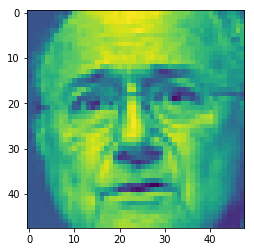

In [17]:
plt.imshow(np.reshape([int(x) for x in dataset["pixels"][5]],(48,48)))

In [28]:
def train_input_fn(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.

    #tf_split = tf.string_split(features,delimiter=' ').values
    #features_split = tf.cast(tf.reshape(tf_split,[48*48]),dtype=tf.float32)
    #features_split = tf.cast(features,dtype=tf.float32)

    
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(1000).repeat().batch(batch_size)

    # Return the dataset.
    return dataset

In [80]:
def eval_input_fn(features, labels=None, batch_size=None):
    """An input function for evaluation or prediction"""
    
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)
    
    # Convert inputs to a tf.dataset object.
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    # Batch the examples
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    # Return the read end of the pipeline.
    return dataset.make_one_shot_iterator().get_next()

![title](emotion_cnn1.png)

In [19]:
def create_conv_layer(inputs,filters,kernels,padding,strides,pools,name,mode):
    #print(inputs,filters,kernels,padding,strides,pools,name,mode)
    conv_layer = tf.contrib.layers.conv2d(
        inputs=inputs,
        num_outputs=filters,
        kernel_size=kernels,
        padding=padding,
        stride=1,
        activation_fn=tf.nn.relu,
        normalizer_fn=tf.contrib.layers.batch_norm
    )
    
    #batch_norm = tf.contrib.layers.batch_norm(
    #    inputs=conv_layer)
    
    relu_act = tf.nn.relu(
        features=conv_layer)
    
    dropout = tf.layers.dropout(
        inputs=relu_act,
        #rate=0.4,
        training = mode == tf.estimator.ModeKeys.TRAIN)
    
    pooling = tf.layers.max_pooling2d(
        inputs=dropout,
        pool_size=pools,
        strides=strides)
    
    return pooling
    

In [20]:
def create_fc_layer(inputs,neurons,mode):
    fc_layer = tf.contrib.layers.fully_connected(
        inputs=inputs,
        num_outputs=neurons
    )
    
    batch_norm = tf.contrib.layers.batch_norm(
        inputs=fc_layer)
    
    dropout = tf.layers.dropout(
        inputs=batch_norm,
        #rate=0.4,
        training=mode == tf.estimator.ModeKeys.TRAIN)
    
    relu_act = tf.nn.relu(
        features=dropout)

    return relu_act
    

In [81]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    n_conv = [(2,3,64),(2,5,128),(2,3,512)]
    n_fc = [256,512]
    
    # Input Layer
    input_layer = tf.reshape(tf.cast(features,tf.float32), [-1, 48, 48, 1])
    print(labels)
    #one_hot_labels = tf.one_hot(labels,7)
    
    conv_layer = input_layer
    
    for s,k,f in n_conv:
        conv_layer = create_conv_layer(
            inputs=conv_layer,
            filters=f,
            kernels=[k,k],
            padding="same",
            strides=s,
            pools=[2,2],
            name="conv"+str(f),
            mode=mode
            )
        
    
    
    fc_layer = tf.reshape(conv_layer,[-1,6*6*512])
    
    for n in n_fc:
        fc_layer = create_fc_layer(
            inputs=fc_layer,
            neurons=n,
            mode=mode
        )
        print(fc_layer)
        
    logits = tf.layers.dense(inputs=fc_layer, units=7)
    
    softmax = tf.nn.softmax(logits, name="softmax_tensor")

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": softmax
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.005)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

# Model Training

In [82]:
emotion_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="tmp/mnist_convnet_model")


tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
  tensors=tensors_to_log, every_n_iter=2000)

tf.logging.set_verbosity(tf.logging.INFO)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_tf_random_seed': None, '_session_config': None, '_task_type': 'worker', '_num_worker_replicas': 1, '_save_checkpoints_secs': 600, '_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8840c2b518>, '_keep_checkpoint_max': 5, '_evaluation_master': '', '_model_dir': 'tmp/mnist_convnet_model', '_global_id_in_cluster': 0, '_service': None, '_save_checkpoints_steps': None, '_log_step_count_steps': 100, '_task_id': 0, '_keep_checkpoint_every_n_hours': 10000, '_is_chief': True, '_num_ps_replicas': 0, '_save_summary_steps': 100, '_train_distribute': None}


In [23]:
def df_to_tensor(series):
    return np.concatenate(series.values).reshape(len(series),len(series[0]))

In [24]:
x = df_to_tensor(dataset["pixels"])
y = dataset["emotion"].values

In [36]:
emotion_classifier.train(
    input_fn=lambda:train_input_fn(
        x,
        y,
        128),
    steps=20*40000,
    hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
Tensor("Relu_3:0", shape=(?, 256), dtype=float32)
Tensor("Relu_4:0", shape=(?, 512), dtype=float32)
Tensor("IteratorGetNext:1", shape=(?,), dtype=int64) Tensor("dense/BiasAdd:0", shape=(?, 7), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tmp/mnist_convnet_model/model.ckpt-365542
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


KeyboardInterrupt: 

In [496]:

np.concatenate(dataset["pixels"].values).reshape(len(dataset["pixels"]),len(dataset["pixels"][0])).shape

(41297, 2304)

## Evaluation

In [47]:
test_df = pd.read_csv("~/data/emotion_reco/test_face_dataset.csv",sep=",")
test_df.rename(columns={"Pixels":"pixels","Emotion":"emotion"},inplace=True)
test_df = test_df.apply(lambda x: string_to_float_list(x),axis=1)

In [48]:
test_df.head()

,emotion,pixels
0,3,"[221.0, 240.0, 251.0, 254.0, 255.0, 255.0, 255..."
1,6,"[100.0, 107.0, 108.0, 104.0, 103.0, 113.0, 117..."
2,4,"[35.0, 50.0, 56.0, 57.0, 63.0, 76.0, 74.0, 79...."
3,6,"[119.0, 124.0, 129.0, 135.0, 136.0, 140.0, 142..."
4,2,"[160.0, 173.0, 186.0, 194.0, 188.0, 185.0, 175..."


In [50]:
x_test = df_to_tensor(test_df["pixels"])
y_test = test_df["emotion"].values

In [51]:
eval_results = emotion_classifier.evaluate(
    input_fn=lambda:eval_input_fn(x_test,y_test,len(y_test)))

INFO:tensorflow:Calling model_fn.
Tensor("Relu_3:0", shape=(?, 256), dtype=float32)
Tensor("Relu_4:0", shape=(?, 512), dtype=float32)
Tensor("IteratorGetNext:1", shape=(?,), dtype=int64, device=/device:CPU:0) Tensor("dense/BiasAdd:0", shape=(?, 7), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-19-08:32:32
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tmp/mnist_convnet_model/model.ckpt-365542
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-19-08:32:34
INFO:tensorflow:Saving dict for global step 365542: accuracy = 0.50957394, global_step = 365542, loss = 4.9671273


## Predictions

In [102]:
def plot_confusion_matrix(y_test,y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [88]:
predictions = emotion_classifier.predict(
    input_fn=lambda:eval_input_fn(x_test,y_test,len(y_test)))

In [89]:
predict_labels = [emot["classes"] for emot in predictions]

INFO:tensorflow:Calling model_fn.
None
Tensor("Relu_3:0", shape=(?, 256), dtype=float32)
Tensor("Relu_4:0", shape=(?, 512), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tmp/mnist_convnet_model/model.ckpt-365542
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [112]:
result = list(zip(*[predict_labels,y_test]))
common_mistakes =[(emotion_string[pred],emotion_string[act],amount) for (pred,act),amount in Counter(result).most_common(20) if pred != act]
print(len(y_test))
common_mistakes

4178


[('Sad', 'Neutral', 293),
 ('Angry', 'Disgust', 274),
 ('Fear', 'Neutral', 139),
 ('Neutral', 'Sad', 115),
 ('Sad', 'Angry', 110),
 ('Surprise', 'Fear', 110),
 ('Happy', 'Neutral', 106),
 ('Neutral', 'Angry', 106),
 ('Fear', 'Surprise', 81),
 ('Fear', 'Sad', 71),
 ('Sad', 'Disgust', 62),
 ('Surprise', 'Neutral', 50),
 ('Sad', 'Fear', 50),
 ('Happy', 'Fear', 48)]

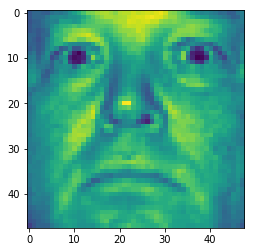

Act: Sad Pred: Neutral


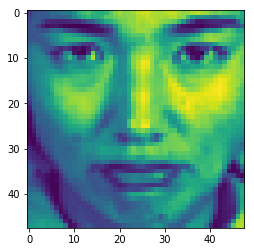

Act: Neutral Pred: Sad


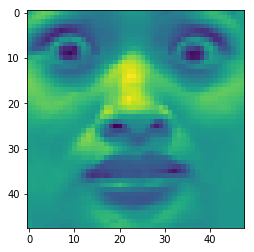

Act: Surprise Pred: Fear


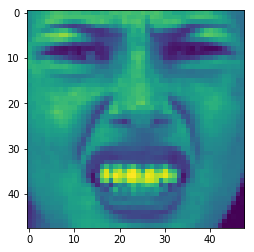

Act: Angry Pred: Disgust


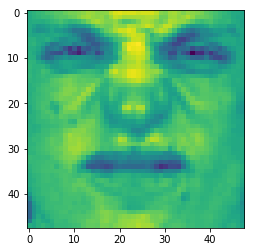

Act: Sad Pred: Disgust


In [111]:
#Some of the wrong predictions
for i in range(10):
    pred,act = result[i]
    if pred != act:
        plt.imshow(np.reshape([int(x) for x in test_df["pixels"][i]],(48,48)))
        plt.show()
        print("Act: {} Pred: {}".format(emotion_string[pred],emotion_string[act]))

In [103]:
plot_confusion_matrix(y_test,predict_labels,list(range(7)))

NameError: name 'confusion_matrix' is not defined